# **Importing Libraries**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# **Download & Explore Dataset**

* https://www.tensorflow.org/datasets/catalog/tf_flowers

In [2]:
(training_set, validation_set), metadata = tfds.load('tf_flowers',
                                                      with_info=True,
                                                      as_supervised=True,
                                                      split=['train[:70%]', 'train[70%:]'])

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [4]:
metadata.name

'tf_flowers'

In [5]:
num_examples = metadata.splits['train'].num_examples
num_examples

3670

In [6]:
num_classes = metadata.features['label'].num_classes
num_classes

5

In [7]:
training_set, validation_set

(<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>)

In [8]:
num_training_examples = len(training_set)
num_validation_examples = len(validation_set)

num_training_examples, num_validation_examples

(2569, 1101)

In [9]:
# Check if all images are of same size or not?
for i, img in enumerate(training_set.take(5)):
  print(img[0].shape)

(333, 500, 3)
(212, 320, 3)
(240, 320, 3)
(240, 320, 3)
(317, 500, 3)


## Reformat Images

In [10]:
IMAGE_SIZE = 299
BATCH_SIZE = 32

In [11]:
def format_images(image, label):
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))/255.0
  return image, label

In [12]:
train_batches = training_set.map(format_images).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_images).batch(BATCH_SIZE).prefetch(1)

In [13]:
train_batches, validation_batches

(<PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int64)>)

## Perform Simple Transfer Learning

In [14]:
URL = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
URL

'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'

In [15]:
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                   trainable=False)
feature_extractor

In [16]:
# # Freeze the variable 
# feature_extractor.trainable = False

In [17]:
# Create a model with last layer equal to num_classes
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes)
])

In [18]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [20]:
EPOCHS = 5

In [21]:
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
81/81 [==============================] - 74s 480ms/step - loss: 0.7354 - accuracy: 0.7435 - val_loss: 0.4335 - val_accuracy: 0.8529
Epoch 2/5
81/81 [==============================] - 34s 420ms/step - loss: 0.3882 - accuracy: 0.8782 - val_loss: 0.3476 - val_accuracy: 0.8783
Epoch 3/5
81/81 [==============================] - 34s 420ms/step - loss: 0.3093 - accuracy: 0.9050 - val_loss: 0.3135 - val_accuracy: 0.8901
Epoch 4/5
81/81 [==============================] - 34s 418ms/step - loss: 0.2622 - accuracy: 0.9221 - val_loss: 0.2960 - val_accuracy: 0.8946
Epoch 5/5
81/81 [==============================] - 34s 420ms/step - loss: 0.2286 - accuracy: 0.9315 - val_loss: 0.2868 - val_accuracy: 0.8992


In [22]:
history.history

{'accuracy': [0.7434799671173096,
  0.878162682056427,
  0.9050214290618896,
  0.9221487045288086,
  0.9314908385276794],
 'loss': [0.735447347164154,
  0.3882126212120056,
  0.30933892726898193,
  0.2621571719646454,
  0.2286171019077301],
 'val_accuracy': [0.8528610467910767,
  0.878292441368103,
  0.8900998830795288,
  0.8946412205696106,
  0.8991825580596924],
 'val_loss': [0.4334554672241211,
  0.34755101799964905,
  0.31346967816352844,
  0.2960076928138733,
  0.286782830953598]}

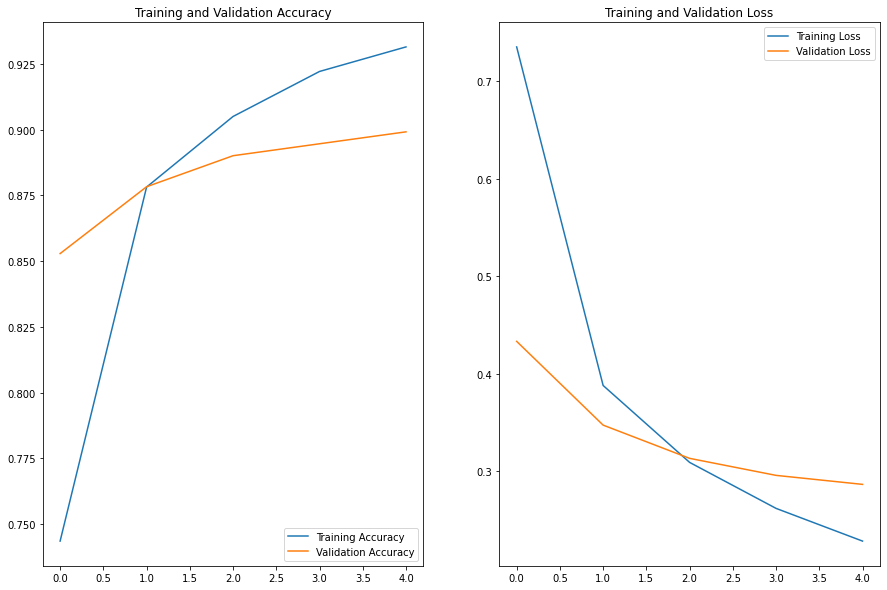

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predictions

In [24]:
num_classes

5

In [25]:
class_names = np.array(metadata.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [26]:
type(class_names)

numpy.ndarray

In [27]:
image_batch, image_label = next(iter(train_batches))

In [28]:
len(image_batch), len(image_label)

(32, 32)

In [29]:
image_batch.shape, image_label.shape

(TensorShape([32, 299, 299, 3]), TensorShape([32]))

In [30]:
image_batch = image_batch.numpy()
image_label = image_label.numpy()

In [31]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
len(predicted_batch), predicted_batch.shape

(32, (32, 5))

In [32]:
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_ids

array([2, 1, 3, 4, 3, 0, 0, 0, 0, 1, 3, 2, 4, 1, 1, 1, 1, 2, 3, 3, 3, 0,
       4, 2, 1, 1, 0, 3, 4, 2, 2, 3])

In [33]:
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['tulips', 'daisy', 'sunflowers', 'roses', 'sunflowers',
       'dandelion', 'dandelion', 'dandelion', 'dandelion', 'daisy',
       'sunflowers', 'tulips', 'roses', 'daisy', 'daisy', 'daisy',
       'daisy', 'tulips', 'sunflowers', 'sunflowers', 'sunflowers',
       'dandelion', 'roses', 'tulips', 'daisy', 'daisy', 'dandelion',
       'sunflowers', 'roses', 'tulips', 'tulips', 'sunflowers'],
      dtype='<U10')

In [34]:
print("Labels:           ", image_label)
print("Predicted labels: ", predicted_ids)

Labels:            [2 3 3 4 3 0 0 0 0 1 3 2 4 1 2 1 1 2 3 3 3 0 3 2 1 1 1 3 4 2 2 3]
Predicted labels:  [2 1 3 4 3 0 0 0 0 1 3 2 4 1 1 1 1 2 3 3 3 0 4 2 1 1 0 3 4 2 2 3]


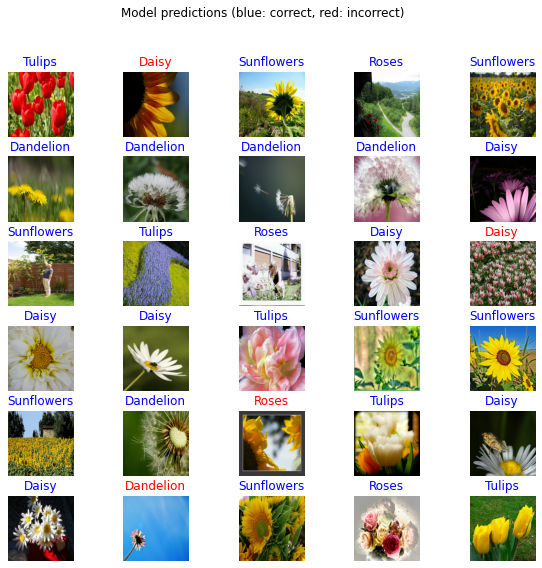

In [35]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == image_label[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")